In [1]:
#Libraries
import pandas as pd
import pandas as pd
from surprise import Reader, Dataset, KNNWithZScore, accuracy, PredictionImpossible
from collections import defaultdict
from surprise.model_selection import KFold
from random import shuffle
import matplotlib.pyplot as plt

#Importing the data
data = pd.read_csv('/home/bbruno/all_here/python course/vinnie/data/cleaned_data/merged_df.csv')
#use cols userId, wine, rating
data = data[['userId', 'wine', 'rate']]
data.head()

,userId,wine,rate
0,826c6abe-7147-4b69-aaea-275fe65b033a,Cavalcaonte Barbera Forlí,5
1,d838a526-4b0a-4fad-b54f-90b6ca321fca,Shiraz,2
2,d838a526-4b0a-4fad-b54f-90b6ca321fca,Pinot Noir,3
3,bec96c0b-5b0b-4992-8756-e0d3b704afb5,Timorasso,5
4,bec96c0b-5b0b-4992-8756-e0d3b704afb5,Le Difese,4


In [2]:
#metrics
metrics_df = pd.DataFrame(
    columns=['Index','Model','Metric','Optimizer','User_based',
             'RMSE','MAE','MSE', 'Precision', 'Recall', 'Accuracy'])
print(metrics_df)

Empty DataFrame
Columns: [Index, Model, Metric, Optimizer, User_based, RMSE, MAE, MSE, Precision, Recall, Accuracy]
Index: []


In [3]:
class KnnWithZSore (KNNWithZScore):
    def __init__(self, sim_options={}, bsl_options = {}):
        KNNWithZScore.__init__(self, sim_options=sim_options, bsl_options= bsl_options)
    
    def create_reader(self, data):
        reader = Reader(rating_scale=(1, 5))
        self.data = Dataset.load_from_df(data[['userId', 'wine', 'rate']], reader)
        
    def fit (self):
        '''Divide the data into train and test manually '''
        #Frist shuffle the data
        raw_ratings = self.data.raw_ratings
        shuffle(raw_ratings)
        
        #75% of the data for training and the rest for testing
        threshold = int(.80 * len(raw_ratings))
        train_raw_ratings = raw_ratings[:threshold]
        test_raw_ratings = raw_ratings[threshold:]
        
        #Update the data object with train raw ratings
        self.data.raw_ratings = train_raw_ratings
        
        #Define a cross-validation iterator
        kf = KFold(n_splits=5, shuffle= True, random_state=42)
        
        train_rmse_list = []
        test_rmse_list = []
        
        for trainset_fold, testset_fold in kf.split(self.data):
            #Train and test algorithm.
            KNNWithZScore.fit(self, trainset_fold)
            train_prediction = KNNWithZScore.test(self, trainset_fold.build_testset())
            prediction = KNNWithZScore.test(self, testset_fold)

            #Error on training
            train_rmse = accuracy.rmse(train_prediction)
            train_rmse_list.append(train_rmse)

            #Error on testing
            test_rmse = accuracy.rmse(prediction)
            test_rmse_list.append(test_rmse)

        avg_train_rmse = sum(train_rmse_list) / len(train_rmse_list)
        avg_test_rmse = sum(test_rmse_list) / len(test_rmse_list)
        print("###############################################")
        print("The Results are: \n")
        print(f"Average RMSE on Training Set: {avg_train_rmse}")
        print(f"Average RMSE on Test Set: {avg_test_rmse}")

        #Predict ratings for all pairs (u, i) that are NOT in the training set.
        #Update the data object with test raw ratings
        self.data.raw_ratings = test_raw_ratings
        #adapting the Testset to be compatible with Surprise
        testset = self.data.construct_testset(self.data.raw_ratings)
        #Predicting the ratings for testset
        predictions = KNNWithZScore.test(self, testset)
        #RMSE
        test_rmse = accuracy.rmse(predictions)
        print(f"RMSE on Test Set on UNSEEN DATA is RMSE, : {test_rmse}")

        self.sim = self.compute_similarities()
        self.bu, self.bi = self.compute_baselines()
        return predictions
    
    def get_user_name(self, uid):
        """Return the name of a user from their id.
        Args:
            uid(int): The raw id of the user.
        Returns:
            The name of the user.
        """
        return self.trainset.to_raw_uid(uid)
    
    def get_item_name(self, iid):
        """Return the name of an item from their id.
        Args:
            iid(int): The raw id of the item.
        Returns:
            The name of the item.
        """
        return self.trainset.to_raw_iid(iid)
    
    def get_neighbors_uid(self, user_id, k=10):
        '''Return the k nearest neighbors of user_id'''
        neighbor_ids = self.get_neighbors(user_id, k=10)
        neighbor_names = [self.get_user_name(uid) for uid in neighbor_ids]
        return neighbor_names
    def get_neighbors_iid(self, item_id, k=10):
        '''Return the k nearest neighbors of item_id'''
        neighbor_ids = self.get_neighbors(item_id, k=10)
        neighbor_names = [self.get_item_name(iid) for iid in neighbor_ids]
        return neighbor_names
        
    def get_top_n_for_user(self, predictions,user_id, n=10):
        """Return the top-N recommendation for a user from a set of predictions.

        Args:
            predictions(list of Prediction objects): The list of predictions, as
                returned by the test method of an algorithm.
            n(int): The number of recommendation to output for each user. Default
                is 10.

        Returns:
        A dict where keys are user (raw) ids and values are lists of tuples:
            [(raw item id, rating estimation), ...] of size n.
        """

        # First map the predictions to each user.
        top_n = defaultdict(list)
        for uid, iid, true_r, est, _ in predictions:
            if uid == user_id:
                top_n[uid].append((iid, est))

        # Then sort the predictions for the user and retrieve the k highest ones.
        user_ratings = top_n[user_id]
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[user_id] = user_ratings[:n]

        return top_n[user_id]
    
    def get_top_n_users_for_item(self, predictions, item_id, n=10):
        """Return the top-N users for a specific item from a set of predictions.

        Args:
            predictions(list of Prediction objects): The list of predictions, as
                returned by the test method of an algorithm.
            item_id: The id of the item for which to get the top-N users.
            n(int): The number of users to output for the item. Default is 10.

        Returns:
        A list of tuples:
            [(raw user id, rating estimation), ...] of size n.
        """

        # First map the predictions to each item.
        top_n = defaultdict(list)
        for uid, iid, true_r, est, _ in predictions:
            if iid == item_id:
                top_n[iid].append((uid, est))

        # Then sort the predictions for the item and retrieve the k highest ones.
        item_ratings = top_n[item_id]
        item_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[item_id] = item_ratings[:n]

        return top_n[item_id]

    def estimated(self, u, i):
        if not (self.trainset.knows_user(u) and self.trainset.knows_item(i)):
            raise PredictionImpossible("User and/or item is unknown.")
        
        #Compute similarities between u and v, where v describes all other
        #users that have also rated item i.
        neighbors = [(v, self.sim[u, v]) for (v, r) in self.trainset.ir[i]]
        # Sort these neighbors by similarity
        neighbors = sorted(neighbors, key=lambda x: x[1], reverse=True)

        print("The 5 nearest neighbors of user", str(u), "are:")
        for v, sim_uv in neighbors[:5]:
            print(f"user {v} with sim {sim_uv:1.15f}")

        # ... Aaaaand return the baseline estimate anyway ;)
        bsl = self.trainset.global_mean + self.bu[u] + self.bi[i]
        return print(f"And the baseline estimate is: {bsl}")
    
    def get_Iu(self, uid):
        """Return the number of items rated by given user
        args:
          uid: the id of the user
        returns:
          the number of items rated by the user
        """
        try:
            return len(self.trainset.ur[self.trainset.to_inner_uid(uid)])
        except ValueError:  # user was not part of the trainset
            return 0

    def get_Ui(self, iid):
        """Return the number of users that have rated given item
        args:
          iid: the raw id of the item
        returns:
          the number of users that have rated the item.
        """
        try:
            return len(self.trainset.ir[self.trainset.to_inner_iid(iid)])
        except ValueError:
            return 0

    def inspect_predictions(self, predictions):
        print(f"uid means the user id and iid means the wine id\n")
        print(f"rui means the actual rating and est means the estimated rating\n")
        print(f"err means the error between the actual and the estimated rating\n")
        print(f"Iu means the number of items rated by given user\n")
        print(f"Ui means the number of users that have rated given item\n")
        # Create a dataframe with the predictions
        df_pred = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
        df_pred['Iu'] = df_pred.uid.apply(self.get_Iu)
        df_pred['Ui'] = df_pred.iid.apply(self.get_Ui)
        df_pred['err'] = abs(df_pred.est - df_pred.rui)
        return df_pred
    
    def get_accuracy(self, predictions, k=10, threshold=3.5):
        #Compute RMSE
        rmse = accuracy.rmse(predictions, verbose=True)
        #Compute MAE
        mae = accuracy.mae(predictions, verbose=True)
        # Compute MSE
        mse = accuracy.mse(predictions, verbose=True)

        #Compute precision and recall
        precisions, recalls = self.precision_recall_at_k(predictions, k=k, threshold=threshold)

        #Precision and recall can then be averaged over all users
        precision = sum(prec for prec in precisions.values()) / len(precisions)
        recall = sum(rec for rec in recalls.values()) / len(recalls)
        print(f'Precision: {precision:.2f}\nRecall: {recall:.2f}')

        #Count correct predictions
        correct = 0
        for uid, iid, true_r, est, _ in predictions:
            if round(est) == round(true_r):
                correct += 1

        #Compute accuracy
        accuracy_percentage = correct / len(predictions)
        accuracy_percentage = accuracy_percentage * 100
        print(f"the acc is {accuracy_percentage:.2f}")

        #Return a dictionary with the metrics
        return {'RMSE': rmse, 'MAE': mae, 'MSE': mse, 'Precision': precision, 'Recall': recall, 'Accuracy': accuracy_percentage}
        
    @staticmethod 
    def precision_recall_at_k(predictions, k=10, threshold=3.5):
        """Return precision and recall at k metrics for each user"""
        # First map the predictions to each user.
        user_est_true = defaultdict(list)
        for uid, _, true_r, est, _ in predictions:
            user_est_true[uid].append((est, true_r))

        precisions = dict()
        recalls = dict()
        for uid, user_ratings in user_est_true.items():
            # Sort user ratings by estimated value
            user_ratings.sort(key=lambda x: x[0], reverse=True)

            # Number of relevant items
            n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

            # Number of recommended items in top k
            n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

            # Number of relevant and recommended items in top k
            n_rel_and_rec_k = sum(
                ((true_r >= threshold) and (est >= threshold))
                for (est, true_r) in user_ratings[:k]
            )

            # Precision@K: Proportion of recommended items that are relevant
            # When n_rec_k is 0, Precision is undefined. We here set it to 0.
            precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

            # Recall@K: Proportion of relevant items that are recommended
            # When n_rel is 0, Recall is undefined. We here set it to 0.
            recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
        return precisions, recalls

## KnnWithZScore SGD

* knn_with_zscore cosine, user based

In [4]:
knn_with_zscore = KnnWithZSore(
    sim_options = {'name': 'cosine','user_based': True}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn_with_zscore.create_reader(data)
predictions = knn_with_zscore.fit()
#acc
metrics = knn_with_zscore.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 1
metrics['Model'] = 'KnnWithZSore'
metrics['Metric'] = 'Cosine'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2363
RMSE: 0.8652
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2245
RMSE: 0.9448
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2497
RMSE: 0.8922
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2699
RMSE: 0.9085
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2426
RMSE: 0.8686
###############################################
The Results are: 

Average RMSE on Training Set: 0.24457101707450804
Average RMSE on Test Set: 0.8958660465098601
RMSE: 0.9390
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.9389953926580314
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 0.9390
MAE:  0.7625
MSE: 0.8817
Precision: 0.57
Recall: 0.62
the acc is 37.62


/tmp/ipykernel_18912/1944145904.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn_with_zscore cosine, item based

In [5]:
knn_with_zscore2 = KnnWithZSore(
    sim_options = {'name': 'cosine','user_based': False}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn_with_zscore2.create_reader(data)
predictions = knn_with_zscore2.fit()
#acc
metrics = knn_with_zscore2.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 2
metrics['Model'] = 'KnnWithZSore'
metrics['Metric'] = 'Cosine'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2900
RMSE: 0.9218
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2838
RMSE: 0.9569
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2627
RMSE: 0.9135
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2709
RMSE: 0.8956
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2614
RMSE: 0.9927
###############################################
The Results are: 

Average RMSE on Training Set: 0.27375746356010505
Average RMSE on Test Set: 0.936089790036372
RMSE: 0.9780
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.9779609001503001
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 0.9780
MAE:  0.7760
MSE: 0.9564
Precision: 0.67
Recall: 0.70
the acc is 44.06


/tmp/ipykernel_18912/2949601189.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18912/2949601189.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn_with_zscore mean squared difference, user based

In [6]:
knn_with_zscore3 = KnnWithZSore(
    sim_options = {'name': 'msd','user_based': True}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn_with_zscore3.create_reader(data)
predictions = knn_with_zscore3.fit()
#acc
metrics = knn_with_zscore3.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 3
metrics['Model'] = 'KnnWithZSore'
metrics['Metric'] = 'MSD'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.1677
RMSE: 0.9371
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.1866
RMSE: 0.8938
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.1962
RMSE: 0.8608
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.1728
RMSE: 0.8564
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.1934
RMSE: 0.9527
###############################################
The Results are: 

Average RMSE on Training Set: 0.18333698063718723
Average RMSE on Test Set: 0.9001875650010387
RMSE: 0.8861
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.8860762428996182
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 0.8861
MAE:  0.6956
MSE: 0.7851
Precision: 0.58
Recall: 0.63
the acc is 45.54


/tmp/ipykernel_18912/2711717971.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18912/2711717971.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn_with_zscore mean squared diference, item based

In [7]:
knn_with_zscore4 = KnnWithZSore(
    sim_options = {'name': 'msd','user_based': False}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn_with_zscore4.create_reader(data)
predictions = knn_with_zscore4.fit()
#acc
metrics = knn_with_zscore4.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 4
metrics['Model'] = 'KnnWithZSore'
metrics['Metric'] = 'MSD'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.1931
RMSE: 0.9795
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2516
RMSE: 0.9658
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2322
RMSE: 0.8943
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2482
RMSE: 0.9146
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2557
RMSE: 0.8379
###############################################
The Results are: 

Average RMSE on Training Set: 0.23615069168653954
Average RMSE on Test Set: 0.918412634067449
RMSE: 1.0402
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.0401916946178775
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 1.0402
MAE:  0.8405
MSE: 1.0820
Precision: 0.63
Recall: 0.65
the acc is 36.14


/tmp/ipykernel_18912/2579909233.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18912/2579909233.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn_with_zscore pearson, user based

In [8]:
knn_with_zscore5 = KnnWithZSore(
    sim_options = {'name': 'pearson','user_based': True}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn_with_zscore5.create_reader(data)
predictions = knn_with_zscore5.fit()
#acc
metrics = knn_with_zscore5.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 5
metrics['Model'] = 'KnnWithZSore'
metrics['Metric'] = 'pearson corr coeff'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1797
RMSE: 0.9558
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1773
RMSE: 0.8382
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1178
RMSE: 0.9553
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1688
RMSE: 0.7616
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1536
RMSE: 0.9272
###############################################
The Results are: 

Average RMSE on Training Set: 0.15943510452725906
Average RMSE on Test Set: 0.887638914693899
RMSE: 1.0022
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.0022059027597856
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 1.0022
MAE:  0.7963
MSE: 1.0044
Precision: 0.63
Recall: 0.70
the acc is 43.56


/tmp/ipykernel_18912/2335934697.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18912/2335934697.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* KnnWithMeans pearson, item based

In [9]:
knn_with_zscore6 = KnnWithZSore(
    sim_options = {'name': 'pearson','user_based': False}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn_with_zscore6.create_reader(data)
predictions = knn_with_zscore6.fit()
#acc
metrics = knn_with_zscore6.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 6
metrics['Model'] = 'KnnWithZSore'
metrics['Metric'] = 'pearson corr coeff'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1255
RMSE: 1.0167
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1789
RMSE: 0.9177
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1566
RMSE: 0.9047
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1647
RMSE: 0.9218
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1260
RMSE: 1.0040
###############################################
The Results are: 

Average RMSE on Training Set: 0.1503349654516005
Average RMSE on Test Set: 0.9529810670679943
RMSE: 0.8813
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.8813177308108016
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 0.8813
MAE:  0.7212
MSE: 0.7767
Precision: 0.64
Recall: 0.69
the acc is 44.06


/tmp/ipykernel_18912/3850417117.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18912/3850417117.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn_with_zscore (shrunk) pearson correlation coefficient, user based

In [10]:
knn_with_zscore7 = KnnWithZSore(
    sim_options = {'name': 'pearson_baseline','user_based': True}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn_with_zscore7.create_reader(data)
predictions = knn_with_zscore7.fit()
#acc
metrics = knn_with_zscore7.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 7
metrics['Model'] = 'KnnWithZSore'
metrics['Metric'] = '(shrunk) pearson corr coeff'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1428
RMSE: 0.9187
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1031
RMSE: 0.9328
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1042
RMSE: 0.8441
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1374
RMSE: 0.8946
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1551
RMSE: 0.9039
###############################################
The Results are: 

Average RMSE on Training Set: 0.12851998445110396
Average RMSE on Test Set: 0.8988080506195711
RMSE: 0.9920
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.992003114791113
Computing the pearson_baseline similarity matrix.

/tmp/ipykernel_18912/2496457707.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18912/2496457707.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn_with_zscore (shrunk) pearson correlation coefficient, item based

In [11]:
knn_with_zscore8 = KnnWithZSore(
    sim_options = {'name': 'pearson_baseline','user_based': False}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn_with_zscore8.create_reader(data)
predictions = knn_with_zscore8.fit()
#acc
metrics = knn_with_zscore8.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 8
metrics['Model'] = 'KnnWithZSore'
metrics['Metric'] = '(shrunk) pearson corr coeff'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1650
RMSE: 0.9704
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1761
RMSE: 0.8627
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1895
RMSE: 0.9274
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1834
RMSE: 0.9333
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1990
RMSE: 0.9120
###############################################
The Results are: 

Average RMSE on Training Set: 0.18258639997508636
Average RMSE on Test Set: 0.9211731549155227
RMSE: 0.9095
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.9094831504519402
Computing the pearson_baseline similarity matrix

/tmp/ipykernel_18912/1008673265.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18912/1008673265.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


## KnnWithZScore Alternating Least Squares (ALS)

* knn_with_zscore cosine, user based

In [12]:
knn_with_zscore9 = KnnWithZSore(
    sim_options = {'name': 'cosine','user_based': True}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn_with_zscore9.create_reader(data)
predictions = knn_with_zscore9.fit()
#acc
metrics = knn_with_zscore9.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 9
metrics['Model'] = 'KnnWithZSore'
metrics['Metric'] = 'Cosine'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2683
RMSE: 0.8487
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2889
RMSE: 0.8415
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2520
RMSE: 0.9251
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2752
RMSE: 0.9132
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2319
RMSE: 0.9619
###############################################
The Results are: 

Average RMSE on Training Set: 0.263259140836993
Average RMSE on Test Set: 0.8980875114785855
RMSE: 0.9328
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.9328378899649067
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 0.9328
MAE:  0.7620
MSE: 0.8702
Precision: 0.64
Recall: 0.71
the acc is 39.11


/tmp/ipykernel_18912/2936597747.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18912/2936597747.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn_with_zscore cosine, item based

In [13]:
knn_with_zscore10 = KnnWithZSore(
    sim_options = {'name': 'cosine','user_based': False}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn_with_zscore10.create_reader(data)
predictions = knn_with_zscore10.fit()
#acc
metrics = knn_with_zscore10.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 10
metrics['Model'] = 'KnnWithZSore'
metrics['Metric'] = 'Cosine'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2714
RMSE: 0.9742
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2821
RMSE: 0.9711
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2927
RMSE: 0.9325
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2857
RMSE: 0.9191
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2886
RMSE: 0.9462
###############################################
The Results are: 

Average RMSE on Training Set: 0.2840996405821078
Average RMSE on Test Set: 0.9486403991900936
RMSE: 0.9229
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.9228675510511267
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 0.9229
MAE:  0.7246
MSE: 0.8517
Precision: 0.72
Recall: 0.75
the acc is 48.02


/tmp/ipykernel_18912/1654456447.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18912/1654456447.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn_with_zscore mean squared difference, user based

In [14]:
knn_with_zscore11 = KnnWithZSore(
    sim_options = {'name': 'msd','user_based': True}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn_with_zscore11.create_reader(data)
predictions = knn_with_zscore11.fit()
#acc
metrics = knn_with_zscore11.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 11
metrics['Model'] = 'KnnWithZSore'
metrics['Metric'] = 'MSD'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2386
RMSE: 0.8848


/tmp/ipykernel_18912/2380454897.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2105
RMSE: 0.9771
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2180
RMSE: 0.9255
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2129
RMSE: 0.9186
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.1993
RMSE: 0.9051
###############################################
The Results are: 

Average RMSE on Training Set: 0.21584403168316352
Average RMSE on Test Set: 0.9222122548214513
RMSE: 0.9026
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.9026030672985682
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 0.9026
MAE:  0.7154
MSE: 0.8147
Precision: 0.70
Recall: 0.75
the acc is 47.03


/tmp/ipykernel_18912/2380454897.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn_with_zscore mean squared difference, item based

In [15]:
knn_with_zscore12 = KnnWithZSore(
    sim_options = {'name': 'msd','user_based': False}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn_with_zscore12.create_reader(data)
predictions = knn_with_zscore12.fit()
#acc
metrics = knn_with_zscore12.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 12
metrics['Model'] = 'KnnWithZSore'
metrics['Metric'] = 'MSD'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2322
RMSE: 1.0261
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2727
RMSE: 0.9358
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2442
RMSE: 0.9882
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2421
RMSE: 1.0151
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2486
RMSE: 0.8911
###############################################
The Results are: 

Average RMSE on Training Set: 0.24793266813928022
Average RMSE on Test Set: 0.9712531773942281
RMSE: 0.8306
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.8306493043329926
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 0.8306
MAE:  0.6590
MSE: 0.6900
Precision: 0.53
Recall: 0.60
the acc is 48.02


/tmp/ipykernel_18912/3404645186.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18912/3404645186.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn_with_zscore pearson correlation coefficient, user based

In [16]:
knn_with_zscore13 = KnnWithZSore(
    sim_options = {'name': 'pearson','user_based': True}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn_with_zscore13.create_reader(data)
predictions = knn_with_zscore13.fit()
#acc
metrics = knn_with_zscore13.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 13
metrics['Model'] = 'KnnWithZSore'
metrics['Metric'] = 'pearson corr coeff'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1615
RMSE: 0.9106
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1503
RMSE: 0.8741
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1189
RMSE: 0.8918
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1388
RMSE: 0.8844
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1268
RMSE: 0.8809
###############################################
The Results are: 

Average RMSE on Training Set: 0.13925679256934545
Average RMSE on Test Set: 0.888349268609022
RMSE: 0.9619
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.9618711303318093
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 0.9619
MAE:  0.7619
MSE: 0.9252
Precision: 0.60
Recall: 0.66
the acc is 40.59


/tmp/ipykernel_18912/1814740321.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18912/1814740321.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn_with_zscore pearson correlation coefficient, item based

In [17]:
knn_with_zscore14 = KnnWithZSore(
    sim_options = {'name': 'pearson','user_based': False}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn_with_zscore14.create_reader(data)
predictions = knn_with_zscore14.fit()
#acc
metrics = knn_with_zscore14.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 14
metrics['Model'] = 'KnnWithZSore'
metrics['Metric'] = 'pearson corr coeff'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1288
RMSE: 0.9430
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1436
RMSE: 0.9989
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1372
RMSE: 0.7939
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1110
RMSE: 0.9368
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1352
RMSE: 0.8926
###############################################
The Results are: 

Average RMSE on Training Set: 0.1311567584599699
Average RMSE on Test Set: 0.9130151421902672
RMSE: 1.0297
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.0296617016146192
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 1.0297
MAE:  0.8194
MSE: 1.0602
Precision: 0.56
Recall: 0.63
the acc is 37.13


/tmp/ipykernel_18912/1740756307.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18912/1740756307.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn_with_zscore (shrunk) pearson correlation coefficient, user based

In [18]:
knn_with_zscore15 = KnnWithZSore(
    sim_options = {'name': 'pearson_baseline','user_based': True}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn_with_zscore15.create_reader(data)
predictions = knn_with_zscore15.fit()
#acc
metrics = knn_with_zscore15.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 15
metrics['Model'] = 'KnnWithZSore'
metrics['Metric'] = '(shrunk) pearson corr coeff'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1704
RMSE: 0.8984
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1296
RMSE: 0.9207
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.2086
RMSE: 0.9023
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1964
RMSE: 0.8885
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1826
RMSE: 0.9362
###############################################
The Results are: 

Average RMSE on Training Set: 0.17751373960431044
Average RMSE on Test Set: 0.9092094325322139
RMSE: 0.9198
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.9197690489000981
Computing the pearson_baseline similarity matrix

/tmp/ipykernel_18912/2066309904.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18912/2066309904.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn_with_zscore (shrunk) pearson correlation coefficient, item based

In [19]:
knn_with_zscore16 = KnnWithZSore(
    sim_options = {'name': 'pearson_baseline','user_based': False}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn_with_zscore16.create_reader(data)
predictions = knn_with_zscore16.fit()
#acc
metrics = knn_with_zscore16.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 16
metrics['Model'] = 'KnnWithZSore'
metrics['Metric'] = '(shrunk) pearson corr coeff'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1828
RMSE: 0.9418
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1828
RMSE: 0.9209
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1485
RMSE: 0.8893
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1588
RMSE: 0.9748
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1234
RMSE: 1.0211
###############################################
The Results are: 

Average RMSE on Training Set: 0.15925295819895396
Average RMSE on Test Set: 0.9495824804613843
RMSE: 0.9307
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.9307488130550318
Computing the pearson_baseline similarity matrix

/tmp/ipykernel_18912/3669178657.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18912/3669178657.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


In [20]:
metrics_df.sort_values(by='RMSE', ascending=True, inplace=True)
metrics_df

,Index,Model,Metric,Optimizer,User_based,RMSE,MAE,MSE,Precision,Recall,Accuracy
11,12,KnnWithZSore,MSD,ALS,False,0.830649,0.659044,0.689978,0.532698,0.595280,48.019802
5,6,KnnWithZSore,pearson corr coeff,SGD,False,0.881318,0.721216,0.776721,0.641097,0.692450,44.059406
2,3,KnnWithZSore,MSD,SGD,True,0.886076,0.695570,0.785131,0.582176,0.634996,45.544554
10,11,KnnWithZSore,MSD,ALS,True,0.902603,0.715426,0.814692,0.702609,0.745400,47.029703
7,8,KnnWithZSore,(shrunk) pearson corr coeff,SGD,False,0.909483,0.721939,0.827160,0.681690,0.727392,42.079208
14,15,KnnWithZSore,(shrunk) pearson corr coeff,ALS,True,0.919769,0.749441,0.845975,0.620000,0.670220,42.574257
9,10,KnnWithZSore,Cosine,ALS,False,0.922868,0.724623,0.851685,0.716414,0.750814,48.019802
15,16,KnnWithZSore,(shrunk) pearson corr coeff,ALS,False,0.930749,0.768171,0.866293,0.663015,0.720748,38.613861
8,9,KnnWithZSore,Cosine,ALS,True,0.932838,0.761979,0.870187,0.643864,0.707463,39.108911
0,1,KnnWithZSore,Cosine,SGD,True,0.938995,0.762543,0.881712,0.566923,0.621368,37.623762


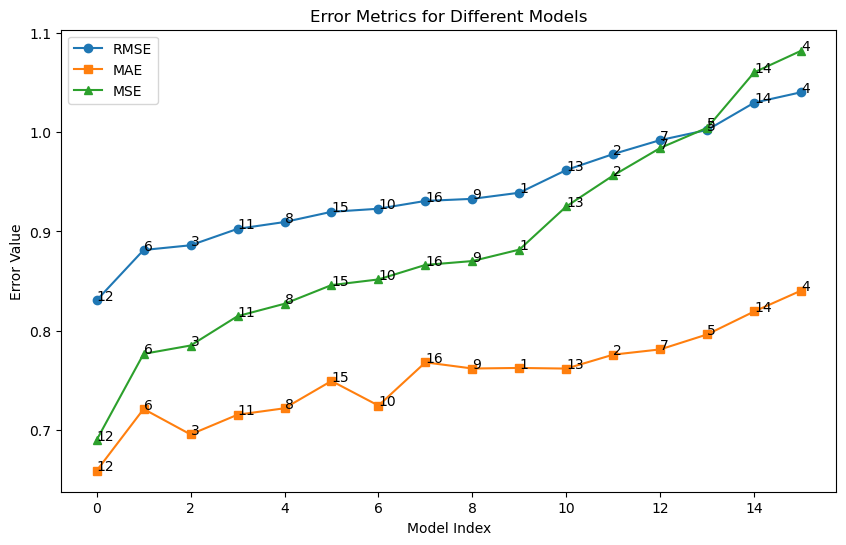

In [21]:
plt.figure(figsize=(10, 6))

#Plot RMSE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['RMSE'], marker='o', linestyle='-', label='RMSE')

#Plot MAE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['MAE'], marker='s', linestyle='-', label='MAE')

#Plot MSE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['MSE'], marker='^', linestyle='-', label='MSE')

#Annotate points with 'Index' column values
for i in range(metrics_df.shape[0]):
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['RMSE'].iloc[i]))
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['MAE'].iloc[i]))
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['MSE'].iloc[i]))

#Setting title and labels
plt.title('Error Metrics for Different Models')
plt.xlabel('Model Index')
plt.ylabel('Error Value')

#legend
plt.legend()
plt.show()

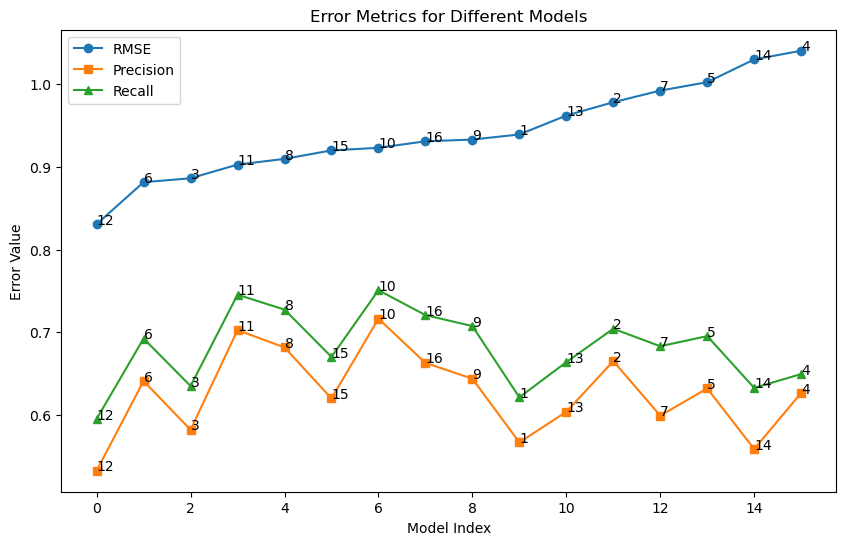

In [22]:
plt.figure(figsize=(10, 6))

#Plot RMSE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['RMSE'], marker='o', linestyle='-', label='RMSE')

#Plot MAE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['Precision'], marker='s', linestyle='-', label='Precision')

#Plot MSE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['Recall'], marker='^', linestyle='-', label='Recall')

#Annotate points with 'Index' column values
for i in range(metrics_df.shape[0]):
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['RMSE'].iloc[i]))
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['Precision'].iloc[i]))
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['Recall'].iloc[i]))

#Setting title and labels
plt.title('Error Metrics for Different Models')
plt.xlabel('Model Index')
plt.ylabel('Error Value')

#legend
plt.legend()
plt.show()

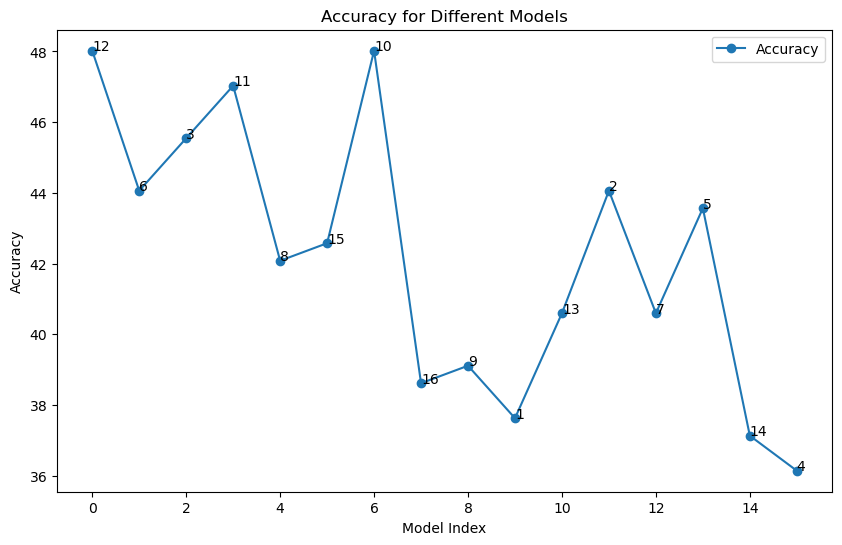

In [23]:
plt.figure(figsize=(10, 6))

#Plot Accuracy with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['Accuracy'], marker='o', linestyle='-', label='Accuracy')

#Annotate points with 'Index' column values
for i in range(metrics_df.shape[0]):
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['Accuracy'].iloc[i]))

#Setting title and labels
plt.title('Accuracy for Different Models')
plt.xlabel('Model Index')
plt.ylabel('Accuracy')

#legend
plt.legend()
plt.show()

## Estimates

In [24]:
#recommends items for a given user from predictions

# user_id = '7f6dede6-b8b5-4bb6-a1ca-ae58c79c0ea7'
# top_n = KnnWithMeans.get_top_n_for_user(predictions, user_id)
# print(user_id, [iid for (iid, _) in top_n])
######### better print
user_id = '7f6dede6-b8b5-4bb6-a1ca-ae58c79c0ea7'
top_n = knn_with_zscore.get_top_n_for_user(predictions, user_id)
print(f"Top items for the user '{user_id}' are:")
for i, (iid, _) in enumerate(top_n, 1):
    print(f"{i}. Item ID: {iid}")

Top items for the user '7f6dede6-b8b5-4bb6-a1ca-ae58c79c0ea7' are:
1. Item ID: Senorino de Baldios
2. Item ID: Pommard
3. Item ID: Ammonite
4. Item ID: Anjou Blanc
5. Item ID: Les Fossiles Riesling
6. Item ID: Clos la Laterne
7. Item ID: Lodi California
8. Item ID: Petit Chablis


In [25]:
# recommneds users for a given item from predictions

# item_id = 'Chardonnay'
# top_n = KnnWithMeans.get_top_n_users_for_item(predictions, item_id)
# print(item_id, [uid for (uid, _) in top_n])
########## better print
item_id = 'Chardonnay'
top_n = knn_with_zscore.get_top_n_users_for_item(predictions, item_id)
print(f"Top users for the item '{item_id}' are:")
for i, (uid, _) in enumerate(top_n, 1):
    print(f"{i}. User ID: {uid}")

Top users for the item 'Chardonnay' are:
1. User ID: 5ccd8030-047b-432c-a630-d784ab415756
2. User ID: 902db46c-a5bf-4d52-acd6-067a2bf3b876


In [26]:
#get the KnnWithMeans for a user from the model
knn_with_zscore.get_neighbors_uid(user_id=5)

['ecc462e1-5041-43ca-94c3-c2bfc9b3215e',
 '13016d41-00bd-411c-83f5-2b95691696b7',
 'd48fd3bd-06e9-4368-97b9-aae545388325',
 'bc8f3005-c2c6-4277-9fd7-340248f4e7ec',
 '76b71bb0-6cc9-4168-8a45-bbafc1e9a256',
 'd7fffb49-a1f3-433c-a556-a3bc015e7e0f',
 '2ae69fac-d491-412f-8164-ccaf59a230c2',
 'a0ef6b50-093e-4ae1-8e3c-58a2a17d2bb8',
 'b61f83a4-48c5-49a5-aee5-72f7d5221b2a',
 '018ad2f2-d320-46c2-8eff-56af0c2ac2b8']

In [27]:
#get the KnnWithMeans for an item from the model
knn_with_zscore.get_neighbors_iid(item_id=20)

['Vitovska legno',
 'Nuovo Vino',
 'Broad Run Pinot Noir',
 'Soave classico',
 'Barolo',
 'La Cerbaiola ',
 'Langhe Nebbiolo',
 'Brunello di Montlcino Mozard',
 'Bardolino',
 'Alazani Valley Red Semi Sweet (ალაზნის ველი წითელი ნახევრად ტკბილი)']

In [28]:
knn_with_zscore.estimated(13,20)
print('\n#####\n')
print("Note: If the baseline is {} then the value is a default value, Otherwise not".format(knn_with_zscore.trainset.global_mean))

The 5 nearest neighbors of user 13 are:
user 11 with sim 0.000000000000000
And the baseline estimate is: 2.854469863387922

#####

Note: If the baseline is 3.6031007751937985 then the value is a default value, Otherwise not


In [29]:
df_pred = knn_with_zscore.inspect_predictions(predictions)
best_pred = df_pred.sort_values(by='err')[:10]
worst_pred = df_pred.sort_values(by='err')[-10:]
df_pred.head(10)

uid means the user id and iid means the wine id

rui means the actual rating and est means the estimated rating

err means the error between the actual and the estimated rating

Iu means the number of items rated by given user

Ui means the number of users that have rated given item



,uid,iid,rui,est,details,Iu,Ui,err
0,dcd16582-14d2-4e00-a024-9b5886d29b29,Alma Mora Reserva Malbec,5.0,3.603101,"{'was_impossible': True, 'reason': 'User and/o...",5,1,1.396899
1,f8c400a6-ded1-40b8-95d2-a263d05c30ce,Pojega,3.0,3.002216,"{'actual_k': 26, 'was_impossible': False}",99,0,0.002216
2,5ccd8030-047b-432c-a630-d784ab415756,Weissburgunder Kallstadter Steinacker,4.0,3.603101,"{'was_impossible': True, 'reason': 'User and/o...",85,0,0.396899
3,675a53a6-ff06-44ad-beea-ddc782c4da96,Il Passito,5.0,3.603101,"{'was_impossible': True, 'reason': 'User and/o...",1,1,1.396899
4,f8c400a6-ded1-40b8-95d2-a263d05c30ce,Flor de Muga,3.0,3.603101,"{'was_impossible': True, 'reason': 'User and/o...",99,0,0.603101
5,ecc462e1-5041-43ca-94c3-c2bfc9b3215e,Bratje Komjanc,3.0,3.603101,"{'was_impossible': True, 'reason': 'User and/o...",25,0,0.603101
6,5ccd8030-047b-432c-a630-d784ab415756,Bel Colle,3.0,3.603101,"{'was_impossible': True, 'reason': 'User and/o...",85,0,0.603101
7,2ae69fac-d491-412f-8164-ccaf59a230c2,Pignolo,4.0,3.000000,"{'actual_k': 0, 'was_impossible': False}",7,1,1.000000
8,e786582d-0deb-4e55-969e-065508ca1138,"Vermentino 2015 ""Campo Maccione""",4.0,3.603101,"{'was_impossible': True, 'reason': 'User and/o...",1,0,0.396899
9,45749629-7f44-49a1-92ef-ae32c959b290,Alberti 154 Malbec,4.0,3.603101,"{'was_impossible': True, 'reason': 'User and/o...",1,0,0.396899


* best predictions

In [30]:
best_pred

,uid,iid,rui,est,details,Iu,Ui,err
56,13016d41-00bd-411c-83f5-2b95691696b7,Cabernet Franc,3.0,3.000000,"{'actual_k': 1, 'was_impossible': False}",13,6,0.000000
37,2a62eecd-b0cd-4395-9f8c-7c912a208be2,Bordeaux,5.0,5.000000,"{'actual_k': 1, 'was_impossible': False}",31,2,0.000000
64,f8c400a6-ded1-40b8-95d2-a263d05c30ce,Chablis Saint Martin,3.0,3.000000,"{'actual_k': 0, 'was_impossible': False}",99,2,0.000000
48,d7fffb49-a1f3-433c-a556-a3bc015e7e0f,Cabernet Franc,3.0,3.000000,"{'actual_k': 0, 'was_impossible': False}",4,6,0.000000
42,f8c400a6-ded1-40b8-95d2-a263d05c30ce,Friulano,3.0,3.000000,"{'actual_k': 0, 'was_impossible': False}",99,4,0.000000
80,f8c400a6-ded1-40b8-95d2-a263d05c30ce,Lagrein,3.0,3.002182,"{'actual_k': 26, 'was_impossible': False}",99,2,0.002182
26,f8c400a6-ded1-40b8-95d2-a263d05c30ce,Bricco Riva Bianca,3.0,3.002216,"{'actual_k': 26, 'was_impossible': False}",99,1,0.002216
1,f8c400a6-ded1-40b8-95d2-a263d05c30ce,Pojega,3.0,3.002216,"{'actual_k': 26, 'was_impossible': False}",99,0,0.002216
198,f8c400a6-ded1-40b8-95d2-a263d05c30ce,Cuvée n 4,3.0,3.002216,"{'actual_k': 26, 'was_impossible': False}",99,2,0.002216
23,f8c400a6-ded1-40b8-95d2-a263d05c30ce,Langhe Nebbiolo,3.0,3.002216,"{'actual_k': 26, 'was_impossible': False}",99,2,0.002216


* worst predictions

In [31]:
worst_pred

,uid,iid,rui,est,details,Iu,Ui,err
177,c2dfb861-cdad-4fb2-9460-fc794c7f6cad,Merlot (U),2.0,3.603101,"{'was_impossible': True, 'reason': 'User and/o...",0,0,1.603101
172,7f6dede6-b8b5-4bb6-a1ca-ae58c79c0ea7,Lodi California,2.0,3.603101,"{'was_impossible': True, 'reason': 'User and/o...",24,1,1.603101
155,ecc462e1-5041-43ca-94c3-c2bfc9b3215e,Sinefinis,2.0,3.603101,"{'was_impossible': True, 'reason': 'User and/o...",25,1,1.603101
185,91cf68cc-9436-43e1-871d-33beef4d2337,Bubbly Pinot Grigio (Champagne),2.0,3.603101,"{'was_impossible': True, 'reason': 'User and/o...",14,1,1.603101
92,5ccd8030-047b-432c-a630-d784ab415756,Acinaia,2.0,3.603101,"{'was_impossible': True, 'reason': 'User and/o...",85,0,1.603101
159,c88644be-2c9b-42f0-9c4b-7f8e81795f43,Bollicina,2.0,3.800000,"{'actual_k': 0, 'was_impossible': False}",1,2,1.800000
57,2ae69fac-d491-412f-8164-ccaf59a230c2,Ribolla Gialla,5.0,3.000000,"{'actual_k': 0, 'was_impossible': False}",7,3,2.000000
153,bc79b0e3-064d-4240-86de-e86499f577e8,2/5 大亂鬥 2,1.0,3.603101,"{'was_impossible': True, 'reason': 'User and/o...",38,0,2.603101
66,ecc462e1-5041-43ca-94c3-c2bfc9b3215e,le vigne di zamo refosco,1.0,3.603101,"{'was_impossible': True, 'reason': 'User and/o...",25,0,2.603101
157,bf82194f-6108-4524-9cef-69c0231ac74b,Nerello mascalese,1.0,3.603101,"{'was_impossible': True, 'reason': 'User and/o...",1,1,2.603101
